In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import wrangle
import acquire
import prepare
import explore

In [59]:
# prepare dataset from script functions
df = wrangle.get_npr_data()

The df has 1889857 rows and 12 columns.


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889857 entries, 0 to 3199856
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   story_id_num     int64  
 1   utterance_order  int64  
 2   speaker          object 
 3   utterance        object 
 4   program          object 
 5   title            object 
 6   is_host          bool   
 7   clean            object 
 8   lemmatized       object 
 9   vader            float64
 10  date             object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 160.4+ MB


In [8]:
def npr_host_vs_guest():
    df['question_mark_count'] = df.utterance.str.count(r"[\?]")

    # create a question mark count df from the above code
    questions = df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                                 .count() \
                                 .reset_index(name = 'count') \
                                 .sort_values(['count'], ascending = False)

    # merge it with the whole df no speaker for viz purposes below
    questions = questions.merge(df, how ='left', on ='speaker').drop(columns = ['story_id_num', 'utterance_order', 'utterance',
           'title','clean', 'lemmatized', 'vader',
           'question_mark_count'])

    plt.figure(figsize = (10, 6))
    viz = sns.boxplot(data = questions, x = 'is_host', y ='count')
    viz.set_xlabel('Host?', fontsize = 13)
    viz.set_ylabel('Count of Questions', fontsize = 13)
    viz.set_title('Do NPR hosts ask more questions than guests?', fontsize = 17);

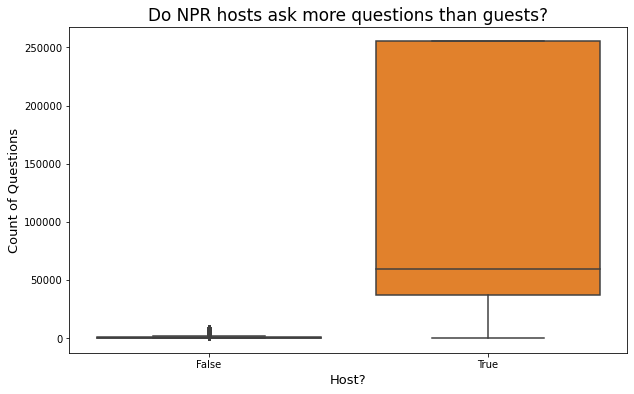

In [10]:
npr_host_vs_guest()

In [13]:
def avg_sentiment_top_speakers():
    # host df
    host_df = df[df.is_host == True]

    # top 10 hosts with the most obseravtions
    hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

    # limits the overal df to. only thee hosts_with_the_most
    top_hosts_df = df[df.speaker.isin(hosts_with_the_most)]

    # boxplots of the sentiment scores of the top hosts
    plt.figure(figsize = (20,10))
    viz = sns.boxplot(data = top_hosts_df,x = 'speaker', y = 'vader')
    viz.set_title('Average Sentiment Score by Top 10 Speakers')
    viz.set_xlabel('Host Name', fontsize = 13)
    viz.set_ylabel('Vader Score', fontsize = 13)
    plt.xticks(rotation = 45);

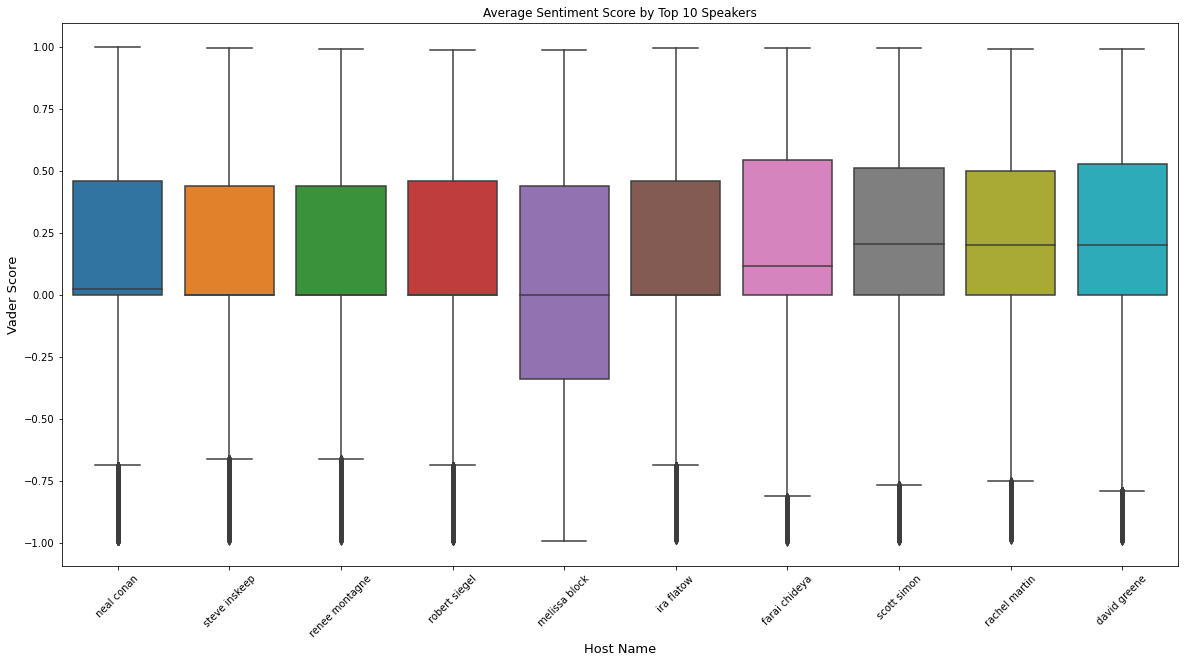

In [27]:
avg_sentiment_top_speakers()

In [16]:
def sentiment_host_nonhost():
    # create a non-host df
    non_host_df = df[df.is_host == False]

    # plot vader score for hosts versus not
    plt.figure
    viz = sns.boxplot(data = df, x = 'is_host', y = 'vader')
    viz.set_xlabel('Host?', fontsize = 13)
    viz.set_ylabel('Mean Sentiment Score', fontsize = 13)
    viz.set_title('Mean Sentiment Score for Hosts vs Non-Hosts', fontsize = 17);

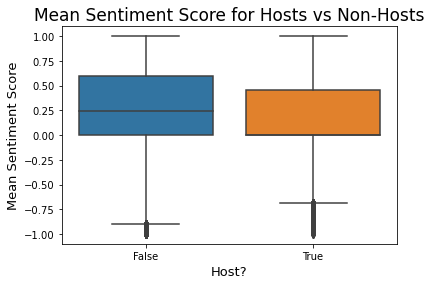

In [17]:
sentiment_host_nonhost()

In [61]:
def episode_sentiment_year():
    # set date to datetime
    viz_df = df.copy()
    
    viz_df['date'] = pd.to_datetime(df.date)

    # set date to index
    viz_df = viz_df.set_index('date').sort_index()

    # resample vader score by year
    viz_df.resample('Y').vader.mean()

    # create yearly vader df
    vader_yearly = pd.DataFrame(viz_df.resample('Y').vader.mean())

    # and plot
    vader_yearly.plot(figsize = (12, 8), title = 'Episode Sentiment Score - 2005 Through 2019')

    viz_df.reset_index(inplace = True);


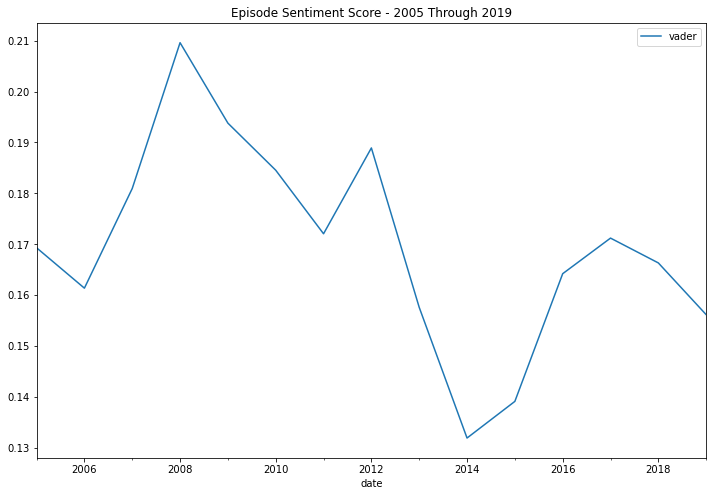

In [62]:
episode_sentiment_year()

In [67]:
def episode_sentiment_month():
    # set date to datetime
    viz_df = df.copy()

    viz_df['date'] = pd.to_datetime(df.date)

    # set date to index
    viz_df = viz_df.set_index('date').sort_index()

    # resample vader score by year
    viz_df.resample('Y').vader.mean()

    # create monthly vader df
    vader_monthly = pd.DataFrame(viz_df.resample('M').vader.mean())

    # and plot
    vader_monthly.plot(figsize = (12, 8), title = 'Episode Sentiment Score by Month - 2005 Through 2019')

    viz_df.reset_index(inplace = True);

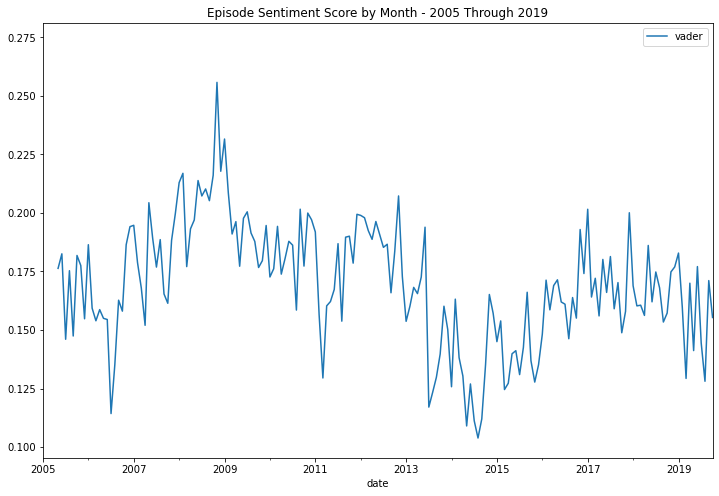

In [68]:
episode_sentiment_month()

In [75]:
def episode_sentiment_weekday():
    # set date to datetime
    viz_df = df.copy()

    viz_df['date'] = pd.to_datetime(viz_df.date)

    # set date to index
    viz_df = viz_df.set_index('date').sort_index()

    # resample vader score by year
    viz_df.resample('Y').vader.mean()

    # sentiment score by  day of week
    viz_df.groupby(viz_df.index.day_name()).vader.mean()

    # sentiment by day, 0 is monday, 6 is sunday

    # plot and order the avg sentiment score by day of week
    order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    plt.figure(figsize = (10,6))
    viz = sns.boxplot(data = viz_df, x = viz_df.index.day_name(), y = 'vader', order = order)
    viz.set_xlabel('Week Day', fontsize = 10)
    viz.set_ylabel('Vader Score', fontsize = 10)
    viz.set_title('Mean Vader Score by Week Day', fontsize = 17)

    viz_df.reset_index(inplace = True);

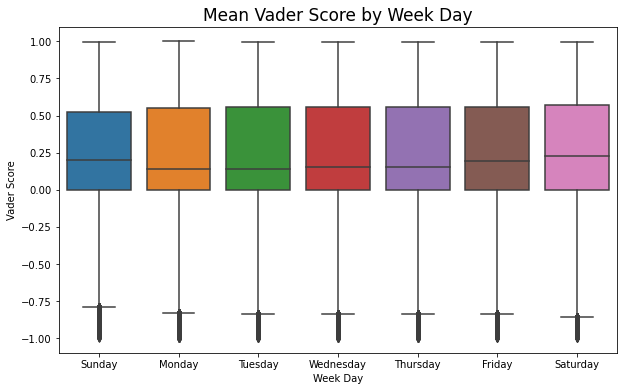

In [76]:
episode_sentiment_weekday()

In [79]:
def program_sentiment():
    viz_df = df.copy()

    viz_df['date'] = pd.to_datetime(viz_df.date)

    # set date to index
    viz_df = viz_df.set_index('date').sort_index()

    #  making df for each program
    talk_of_the_nation_df = viz_df[viz_df.program == 'talk of the nation']
    morning_edition_df = viz_df[viz_df.program == 'morning edition']
    all_things_considered_df = viz_df[viz_df.program == 'all things considered']
    news_and_notes_df = viz_df[viz_df.program == 'news & notes']
    weekend_edition_saturday_df = viz_df[viz_df.program == 'weekend edition saturday']
    weekend_edition_sunday_df = viz_df[viz_df.program == 'weekend edition sunday']
    day_to_day_df = viz_df[viz_df.program == 'day to day']

    # plot the  sentimen over time of each program
    plt.figure(figsize = (30,10))

    talk_of_the_nation_df.resample("y").vader.mean().plot(alpha = .5)
    all_things_considered_df.resample("y").vader.mean().plot(alpha = .5)
    morning_edition_df.resample("y").vader.mean().plot(alpha = .5)
    news_and_notes_df.resample("y").vader.mean().plot(alpha = .5)
    day_to_day_df.resample("y").vader.mean().plot(alpha = .5)
    weekend_edition_sunday_df.resample("y").vader.mean().plot(alpha = .5)
    weekend_edition_saturday_df.resample("y").vader.mean().plot(alpha = .5)

    plt.title("Average Sentiment Over Time, by Program")
    plt.legend(['Talk of the Nation',
     'All Things Considered',
     'Morning Edition',
     'News & Notes',
     'Day to Day',
     'Weekend Edition Sunday',
     'Weekend Edition Saturday'], prop = {'size': 20});

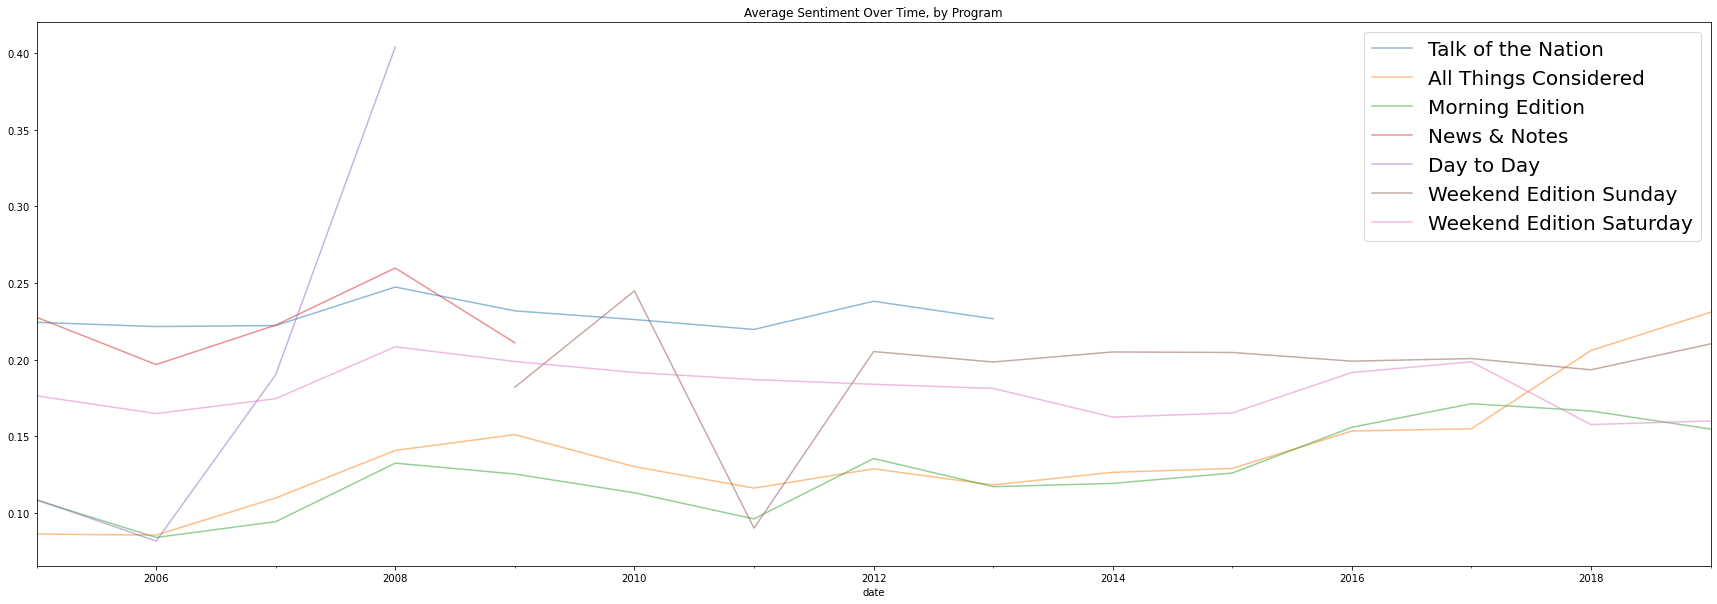

In [80]:
program_sentiment()

In [82]:
#def host_wordclouds():

def string_cleaning(s):
    '''
    Function to remove punctuation from word frequencies for hosts.
    '''
    # remove special characters
    s = re.sub(r"[^a-z0-9'\s\?]", '', s)

    return s

# adding in additional stopwords

more_stopwords = pd.read_excel('stop_words_df.xlsx')
more_stopwords = more_stopwords.words.to_list()

host_words = host_words.apply(string_cleaning).apply(prepare.remove_stopwords, extra_words = more_stopwords)

# create word frequencies for each host
greene_freq = pd.Series(host_words['david greene'].split()).value_counts()
martin_freq = pd.Series(host_words['rachel martin'].split()).value_counts()
simon_freq = pd.Series(host_words['scott simon'].split()).value_counts()
chideya_freq = pd.Series(host_words['farai chideya'].split()).value_counts()
montagne_freq = pd.Series(host_words['renee montagne'].split()).value_counts()
block_freq = pd.Series(host_words['melissa block'].split()).value_counts()
siegel_freq = pd.Series(host_words['robert siegel'].split()).value_counts()
inskeep_freq = pd.Series(host_words['steve inskeep'].split()).value_counts()
flatow_freq = pd.Series(host_words['ira flatow'].split()).value_counts()
conan_freq = pd.Series(host_words['neal conan'].split()).value_counts()

# create dictionary for word clouds
word_lists = {'conan': host_words['neal conan'], 
'flatow': host_words['ira flatow'], 
'inskeep': host_words['steve inskeep'], 
'siegel': host_words['robert siegel'], 
'block': host_words['melissa block'], 
'montagne': host_words['renee montagne'], 
'chideya': host_words['farai chideya'], 
'simon': host_words['scott simon'], 
'martin': host_words['rachel martin'], 
'greene': host_words['david greene']}

# word clouds
for h in word_lists:
    plt.figure(figsize = (7,7))
    img = WordCloud(background_color = 'white', width = 800, height = 600).generate(word_lists[h])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{h}')
    plt.show()

NameError: name 'host_words' is not defined